# Decision Trees & Random Forests

__Team Members:__ Surya Suresh Sriraman, Nivetha Sivakumar, Aravind Raju

# Introduction

This work will explore a dataset comprised of more than 73,000 observations, each of which pertains to a particular NY State school district and associated subgroupings/categorizations of high school students who had been enrolled for at least 4 years as of the end of the 2018-2019 school year. The primary objective of the project is to construct and compare/contrast a series of decision tree and random forest models that predicts whether the percentage of students awarded a "Regents" diploma is low, medium or high for a given school district / student subgrouping.

__Approach:__<br>
- __Develop Domain Knowledge:__ Gain an understanding of the educational landscape, variables, and factors influencing high school students' performance and enrollment in NY State school districts.
- __Data Loading:__ Utilize Python and the Pandas library to load the data into a suitable DataFrame.
- __Exploratory Data Analysis (EDA):__  Explore and analyze the dataset to identify patterns, trends, and relationships. This step involves data visualization, summary statistics, and initial insights to inform subsequent analyses.
- __Data Preparation:__ Clean and preprocess the data to handle missing values, outliers, and ensure it is in a suitable format for analysis. This step may involve feature engineering and encoding categorical variables.
- __Prep Data Review:__ Review the prepared dataset to ensure that transformations and preprocessing steps have been applied correctly. Confirm that the data is ready for modeling.
- __Decision Tree + Random Forest Modelling:__ Split the dataset into training and testing subsets, and train a series of decision tree and random forest models on the training data.
- __Select Best Performing Model:__ Use Cross Validation to evaluate and compare the performance of the models. Select the vest performing model and apply it on the test data to assess how well it performs on that previously unseen data.

## Import Libraries

In [37]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Loading

In [2]:
# Define column data types based on domain knowledge
column_types = {
    'report_school_year' : object,
    'aggregation_index' : object,
    'aggregation_type' : object,
    'aggregation_name' : object,
    'nrc_code' : object,
    'nrc_desc' : object,
    'county_code' : object,
    'county_name' : object,
    'nyc_ind' : bool,
    'membership_desc' : object, 
    'subgroup_code' : object,
    'subgroup_name' : object,
    'enroll_cnt' : float,
    'grad_cnt' : float,
    'grad_pct' : object,
    'reg_cnt' : float,
    'reg_pct' : object,
    'dropout_cnt' : float,
    'dropout_pct' : object
}

# Load data into Pandas DataFrame 
school_df = pd.read_csv(r"https://raw.githubusercontent.com/s-surya-s/DAV-6150/main/M11_Data.csv", sep = ",", engine = 'python', na_values='-', dtype=column_types)

#Fix Datatypes
pct_col = ['grad_pct', 'reg_pct', 'dropout_pct']
school_df[pct_col] = school_df[pct_col].apply(lambda x: x.str.replace('%', '')).astype(float)

# sanity check - make sure data was read in as expected
school_df.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,1,All Students,658.0,464.0,71.0,310.0,47.0,148.0,22.0
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,2,Female,324.0,246.0,76.0,169.0,52.0,65.0,20.0
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,3,Male,334.0,218.0,65.0,141.0,42.0,83.0,25.0
3,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,4,American Indian/Alaska Native,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,False,2013 Total Cohort - 6 Year Outcome,5,Black,367.0,248.0,68.0,183.0,50.0,91.0,25.0


# Exploratory Data Analysis

## Data Summary

In [3]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73152 entries, 0 to 73151
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   report_school_year  73152 non-null  object 
 1   aggregation_index   73152 non-null  object 
 2   aggregation_type    73152 non-null  object 
 3   aggregation_name    73152 non-null  object 
 4   nrc_code            73152 non-null  object 
 5   nrc_desc            73152 non-null  object 
 6   county_code         73152 non-null  object 
 7   county_name         73152 non-null  object 
 8   nyc_ind             73152 non-null  bool   
 9   membership_desc     73152 non-null  object 
 10  subgroup_code       73152 non-null  object 
 11  subgroup_name       73152 non-null  object 
 12  enroll_cnt          39674 non-null  float64
 13  grad_cnt            39674 non-null  float64
 14  grad_pct            39674 non-null  float64
 15  reg_cnt             39674 non-null  float64
 16  reg_

## Summary Statistics

In [4]:
num_cols = school_df.select_dtypes(include='float64').columns
cat_cols = school_df.select_dtypes(include=['bool', 'object']).columns

print('Numeric Columns')
display(school_df[num_cols].describe())
print('Category Columns')
display(school_df[cat_cols].describe())

Numeric Columns


,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
count,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000
mean,192.120079,161.178354,84.406614,86.804708,43.371125,16.239225,7.963049
std,439.972474,361.294773,15.679500,225.795826,17.124891,50.129834,9.658698
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,20.000000,79.000000,10.000000,33.000000,1.000000,1.000000
50%,66.000000,57.000000,89.000000,27.000000,43.000000,3.000000,5.000000
75%,179.000000,156.000000,95.000000,69.000000,53.000000,9.000000,11.000000
max,9176.000000,7540.000000,100.000000,4752.000000,100.000000,1091.000000,100.000000


Category Columns


,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name
count,73152,73152,73152,73152,73152,73152,73152,73152,73152,73152,73152,73152
unique,1,1,1,680,6,6,62,62,2,6,24,24
top,2018-19,3,District,KINGSTON CITY SCHOOL DISTRICT,5,Average Needs,58,SUFFOLK,False,2015 Total Cohort - 4 Year Outcome,1,All Students
freq,73152,73152,73152,138,35322,35322,6526,6526,69110,12299,4074,4074


In [5]:
# Check Duplicates
'Duplicates Found' if school_df.duplicated().any() else 'No Duplicates'

'No Duplicates'

In [6]:
#Check Nulls
'Nulls Found' if school_df.isnull().sum().sum() != 0 else 'No Nulls'

'Nulls Found'

## Univariate Analysis

In [7]:
# Function for Univariate Analysis

def Univariate_EDA(df, col):
    '''
    Performs Univariate Analysis

    Args:
    - df: Dataframe for Univariate analysis
    - col: Column in the df for Univariate analysis

    Returns:
    None
    '''
    
    print('\n','-'*20, col,'-'*20)

    # Temporarily remove null values to view the distribution
    df = df[df[col].notnull()]
    
    # get summary statistics
    print('Summary Statistics')
    display(df[col].describe())
    
    if df[col].dtype == 'object' or df[col].dtype == 'bool':
        # Display unique values
        if len(df[col].unique())<=10:
            print('Unique Values')
            display(df[col].unique())
        else:
            print('Note: The graph displays only the top 20 frequent values')

        # Create a bar plot of the value counts
        plt.figure(figsize=(6, 5))
        plt.title(col)

        # Get value counts for the variable
        frequency = df[col].value_counts().head(20)
        sns.barplot(x=frequency.index, y=frequency.values, palette="viridis")
        plt.title(col)
        plt.ylabel("Counts")
        plt.tick_params(axis='x', rotation=90)

        # Display plot
        plt.tight_layout()
        plt.show()
        
        print("Insights:")
        if len(df[col].unique()) == 1:
            print(f"The {col} has only one unique value, {df[col].unique()[0]}")
        else:
            print("The {} column is comprised of {} distinct categorical values, with the most frequently occurring value being '{}'".format(col, len(df[col].unique()),df[col].mode()[0]))
    
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':

        plt.figure(figsize=(6, 3))
        plt.suptitle(col)

        # Plot histogram
        plt.subplot(1, 2, 1)
        #sns.histplot(data=df, x=col, kde=True, color='skyblue')
        df[col].hist()

        # Plot boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x=col, color='green')

        # Display plot
        plt.tight_layout()
        plt.show()

        print("Insights:")
        # Check skewness and distribution
        if df[col].median() == df[col].mean():
            skewtext = 'the median equals the mean. Plot shows normal distribution.'
        elif df[col].median() > df[col].mean():
            skewtext = 'median exceeds mean. Plot shows left skewness.'
        else:
            skewtext = 'mean exceeds median. Plot shows right skewness.'

        print(f'Summary statistics, histogram, and boxplot indicate {skewtext}\nThe values range between {df[col].min()} and {df[col].max()}.')

        # Outliers detection
        q1 = np.quantile(df[col], 0.25)
        q3 = np.quantile(df[col], 0.75)
        iqr = q3 - q1
        upper_bound = q3 + (1.5 * iqr)
        lower_bound = q1 - (1.5 * iqr)
        outlier = (df[col] < lower_bound) | (df[col] > upper_bound)

        # Display outliers information
        if outlier.sum() > 0:
            print('Outliers Detected!')
            print('Outliers%: {}'.format(round(100 * outlier.mean(), 2)))

    return None


 -------------------- report_school_year --------------------
Summary Statistics


count       73152
unique          1
top       2018-19
freq        73152
Name: report_school_year, dtype: object

Unique Values


array(['2018-19'], dtype=object)

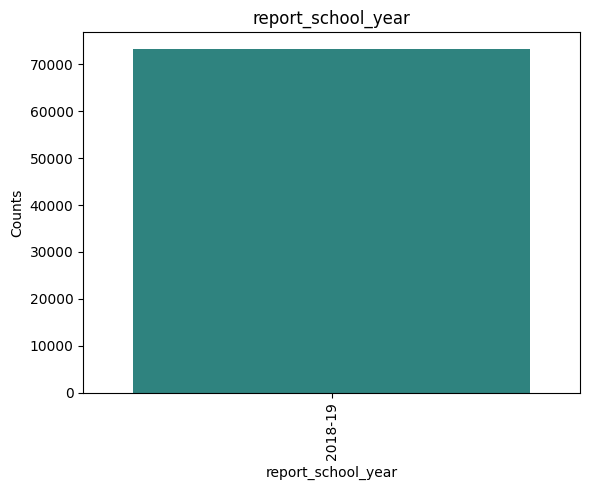

Insights:
The report_school_year has only one unique value, 2018-19

 -------------------- aggregation_index --------------------
Summary Statistics


count     73152
unique        1
top           3
freq      73152
Name: aggregation_index, dtype: object

Unique Values


array(['3'], dtype=object)

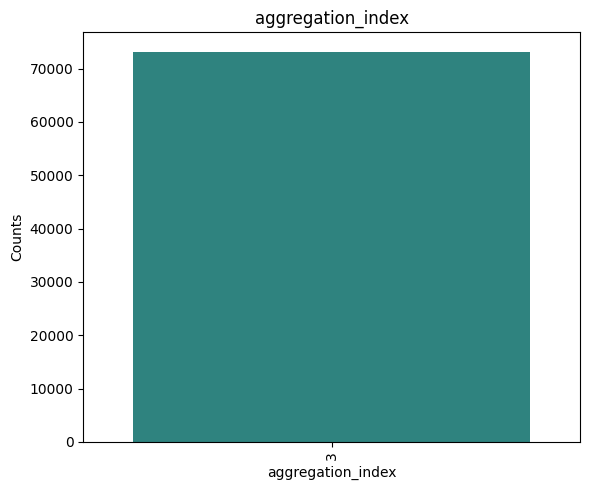

Insights:
The aggregation_index has only one unique value, 3

 -------------------- aggregation_type --------------------
Summary Statistics


count        73152
unique           1
top       District
freq         73152
Name: aggregation_type, dtype: object

Unique Values


array(['District'], dtype=object)

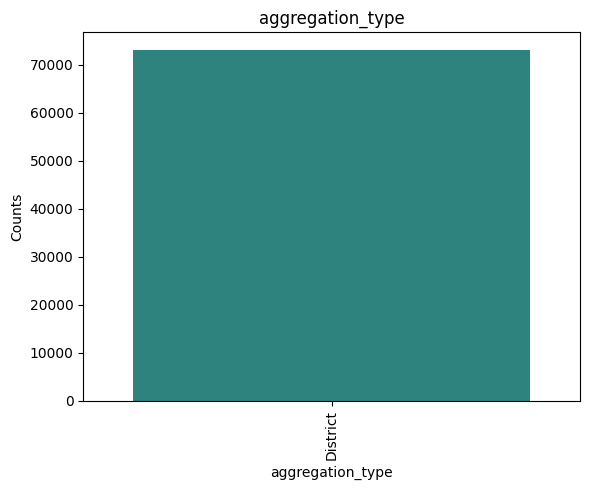

Insights:
The aggregation_type has only one unique value, District

 -------------------- aggregation_name --------------------
Summary Statistics


count                             73152
unique                              680
top       KINGSTON CITY SCHOOL DISTRICT
freq                                138
Name: aggregation_name, dtype: object

Note: The graph displays only the top 20 frequent values


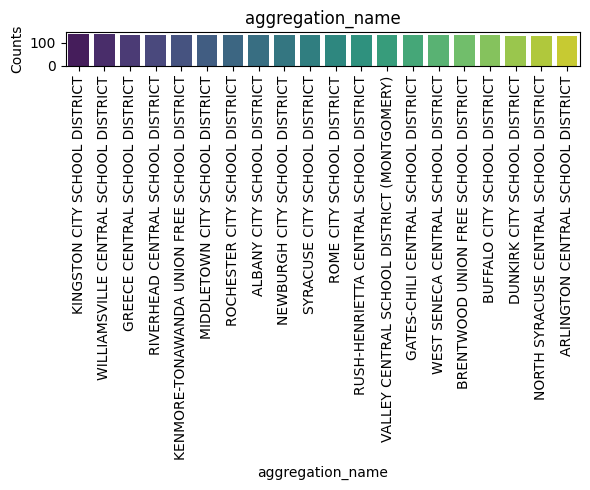

Insights:
The aggregation_name column is comprised of 680 distinct categorical values, with the most frequently occurring value being 'KINGSTON CITY SCHOOL DISTRICT'

 -------------------- nrc_code --------------------
Summary Statistics


count     73152
unique        6
top           5
freq      35322
Name: nrc_code, dtype: object

Unique Values


array(['3', '5', '6', '4', '2', '1'], dtype=object)

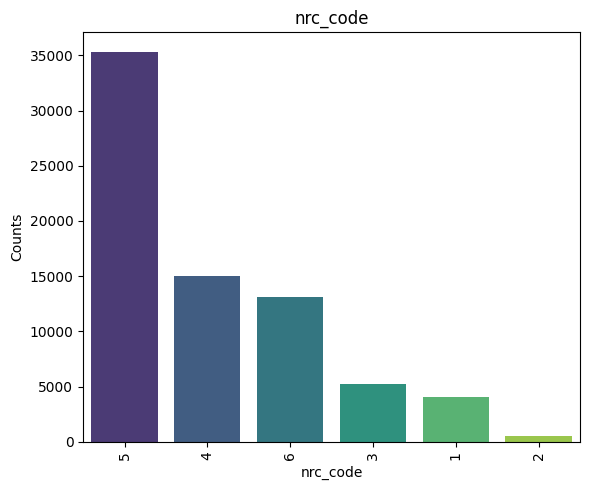

Insights:
The nrc_code column is comprised of 6 distinct categorical values, with the most frequently occurring value being '5'

 -------------------- nrc_desc --------------------
Summary Statistics


count             73152
unique                6
top       Average Needs
freq              35322
Name: nrc_desc, dtype: object

Unique Values


array(['Urban-Suburban High Needs', 'Average Needs', 'Low Needs',
       'Rural High Needs', 'Buffalo  Rochester  Yonkers  Syracuse', 'NYC'],
      dtype=object)

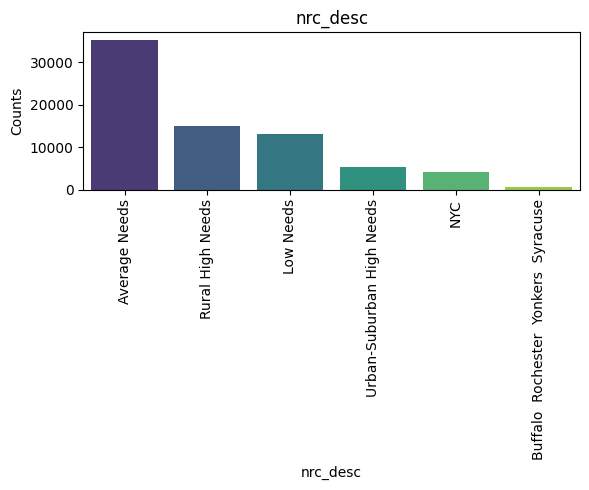

Insights:
The nrc_desc column is comprised of 6 distinct categorical values, with the most frequently occurring value being 'Average Needs'

 -------------------- county_code --------------------
Summary Statistics


count     73152
unique       62
top          58
freq       6526
Name: county_code, dtype: object

Note: The graph displays only the top 20 frequent values


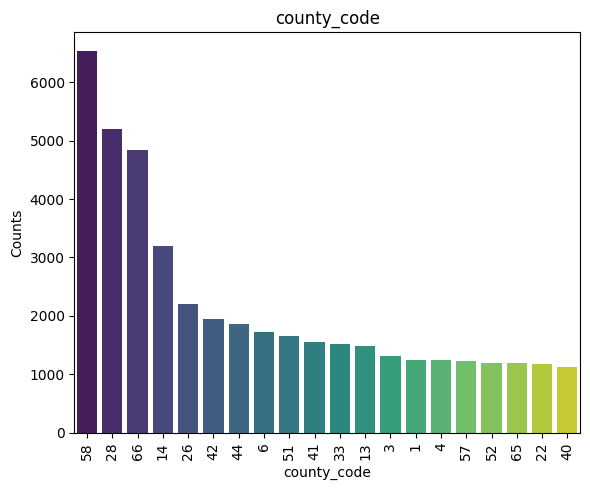

Insights:
The county_code column is comprised of 62 distinct categorical values, with the most frequently occurring value being '58'

 -------------------- county_name --------------------
Summary Statistics


count       73152
unique         62
top       SUFFOLK
freq         6526
Name: county_name, dtype: object

Note: The graph displays only the top 20 frequent values


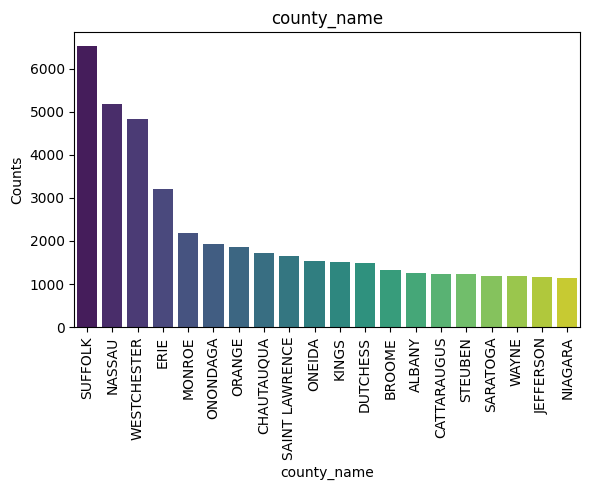

Insights:
The county_name column is comprised of 62 distinct categorical values, with the most frequently occurring value being 'SUFFOLK'

 -------------------- nyc_ind --------------------
Summary Statistics


count     73152
unique        2
top       False
freq      69110
Name: nyc_ind, dtype: object

Unique Values


array([False,  True])

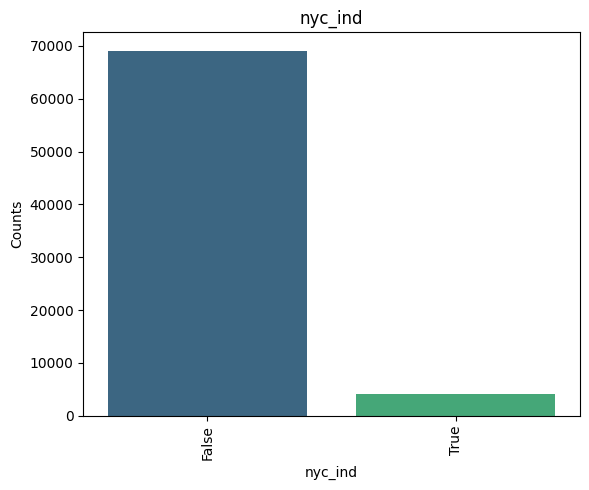

Insights:
The nyc_ind column is comprised of 2 distinct categorical values, with the most frequently occurring value being 'False'

 -------------------- membership_desc --------------------
Summary Statistics


count                                  73152
unique                                     6
top       2015 Total Cohort - 4 Year Outcome
freq                                   12299
Name: membership_desc, dtype: object

Unique Values


array(['2013 Total Cohort - 6 Year Outcome',
       '2014 Total Cohort - 5 Year Outcome',
       '2015 Total Cohort - 4 Year Outcome',
       '2014 Total Cohort - 5 Year Outcome - August 2019',
       '2015 Total Cohort - 4 Year Outcome - August 2019',
       '2013 Total Cohort - 6 Year Outcome - August 2019'], dtype=object)

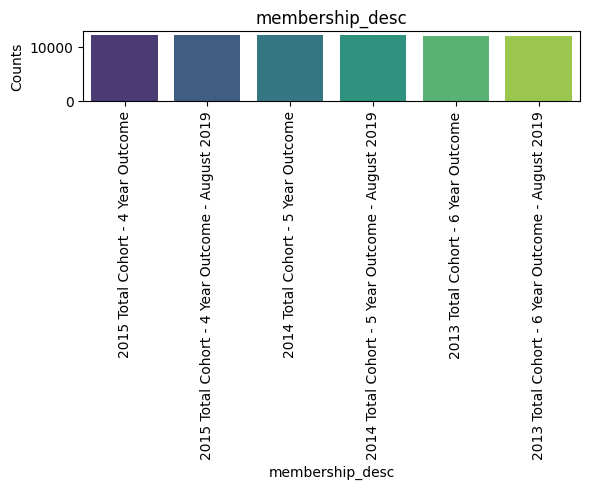

Insights:
The membership_desc column is comprised of 6 distinct categorical values, with the most frequently occurring value being '2015 Total Cohort - 4 Year Outcome'

 -------------------- subgroup_code --------------------
Summary Statistics


count     73152
unique       24
top           1
freq       4074
Name: subgroup_code, dtype: object

Note: The graph displays only the top 20 frequent values


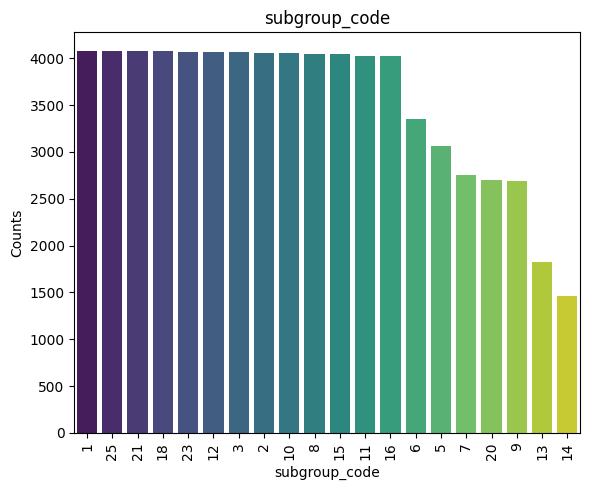

Insights:
The subgroup_code column is comprised of 24 distinct categorical values, with the most frequently occurring value being '1'

 -------------------- subgroup_name --------------------
Summary Statistics


count            73152
unique              24
top       All Students
freq              4074
Name: subgroup_name, dtype: object

Note: The graph displays only the top 20 frequent values


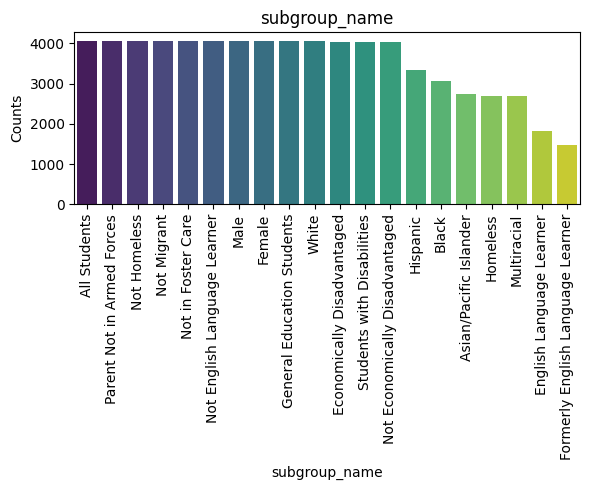

Insights:
The subgroup_name column is comprised of 24 distinct categorical values, with the most frequently occurring value being 'All Students'

 -------------------- enroll_cnt --------------------
Summary Statistics


count    39674.000000
mean       192.120079
std        439.972474
min          5.000000
25%         25.000000
50%         66.000000
75%        179.000000
max       9176.000000
Name: enroll_cnt, dtype: float64

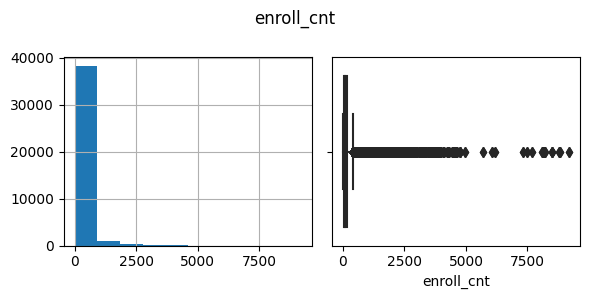

Insights:
Summary statistics, histogram, and boxplot indicate mean exceeds median. Plot shows right skewness.
The values range between 5.0 and 9176.0.
Outliers Detected!
Outliers%: 9.98

 -------------------- grad_cnt --------------------
Summary Statistics


count    39674.000000
mean       161.178354
std        361.294773
min          0.000000
25%         20.000000
50%         57.000000
75%        156.000000
max       7540.000000
Name: grad_cnt, dtype: float64

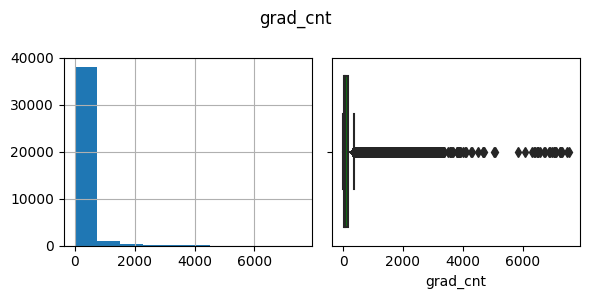

Insights:
Summary statistics, histogram, and boxplot indicate mean exceeds median. Plot shows right skewness.
The values range between 0.0 and 7540.0.
Outliers Detected!
Outliers%: 9.79

 -------------------- grad_pct --------------------
Summary Statistics


count    39674.000000
mean        84.406614
std         15.679500
min          0.000000
25%         79.000000
50%         89.000000
75%         95.000000
max        100.000000
Name: grad_pct, dtype: float64

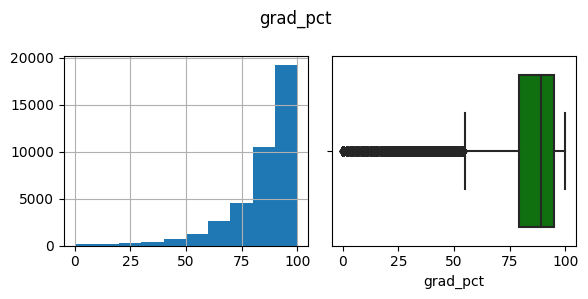

Insights:
Summary statistics, histogram, and boxplot indicate median exceeds mean. Plot shows left skewness.
The values range between 0.0 and 100.0.
Outliers Detected!
Outliers%: 5.59

 -------------------- reg_cnt --------------------
Summary Statistics


count    39674.000000
mean        86.804708
std        225.795826
min          0.000000
25%         10.000000
50%         27.000000
75%         69.000000
max       4752.000000
Name: reg_cnt, dtype: float64

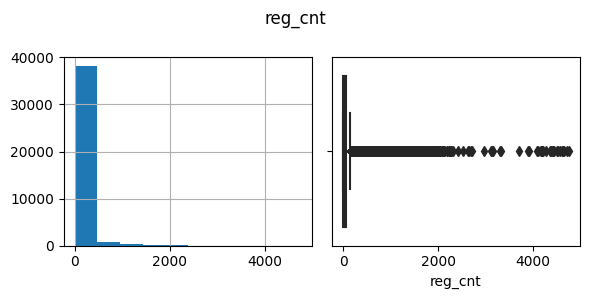

Insights:
Summary statistics, histogram, and boxplot indicate mean exceeds median. Plot shows right skewness.
The values range between 0.0 and 4752.0.
Outliers Detected!
Outliers%: 10.82

 -------------------- reg_pct --------------------
Summary Statistics


count    39674.000000
mean        43.371125
std         17.124891
min          0.000000
25%         33.000000
50%         43.000000
75%         53.000000
max        100.000000
Name: reg_pct, dtype: float64

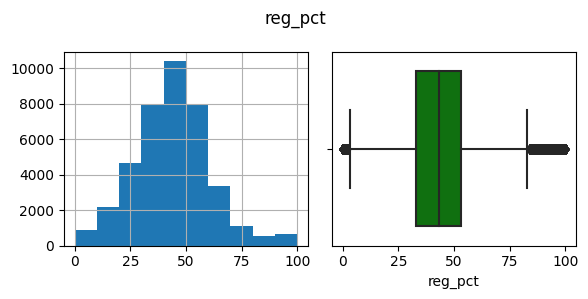

Insights:
Summary statistics, histogram, and boxplot indicate mean exceeds median. Plot shows right skewness.
The values range between 0.0 and 100.0.
Outliers Detected!
Outliers%: 3.27

 -------------------- dropout_cnt --------------------
Summary Statistics


count    39674.000000
mean        16.239225
std         50.129834
min          0.000000
25%          1.000000
50%          3.000000
75%          9.000000
max       1091.000000
Name: dropout_cnt, dtype: float64

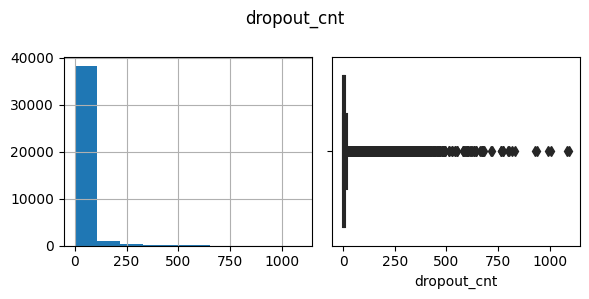

Insights:
Summary statistics, histogram, and boxplot indicate mean exceeds median. Plot shows right skewness.
The values range between 0.0 and 1091.0.
Outliers Detected!
Outliers%: 12.91

 -------------------- dropout_pct --------------------
Summary Statistics


count    39674.000000
mean         7.963049
std          9.658698
min          0.000000
25%          1.000000
50%          5.000000
75%         11.000000
max        100.000000
Name: dropout_pct, dtype: float64

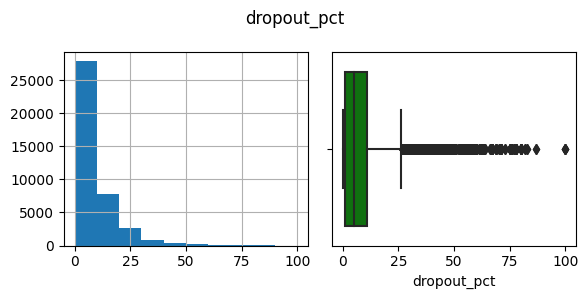

Insights:
Summary statistics, histogram, and boxplot indicate mean exceeds median. Plot shows right skewness.
The values range between 0.0 and 100.0.
Outliers Detected!
Outliers%: 4.86


In [8]:
for col in school_df.columns:    
    Univariate_EDA(school_df, col)

## Bivariate Analysis

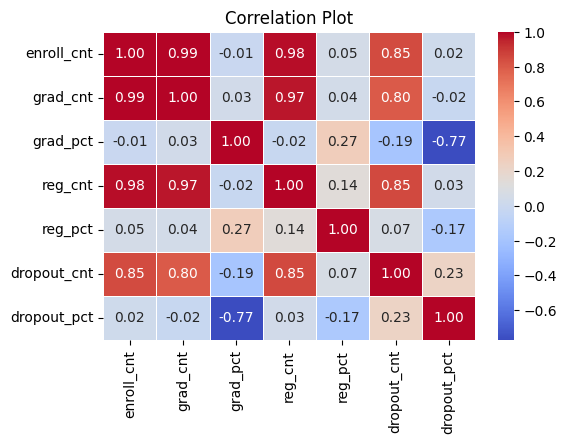

In [9]:
# Calculate the correlation matrix
correlation_matrix = school_df[num_cols].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot')
plt.show()

__Insights:__ 
The following columns are highly correlated
- enroll_cnt and grad_cnt 
- enroll_cnt and reg_cnt 
- enroll_cnt and dropout_cnt
- dropout_pct and grad_pct

# Data Preparation

## Prepare Target Variable

In [12]:
# Calculate the median percentage of regent diplomas awarded
median_reg_pct = school_df["reg_pct"].median()

# Create a new categorical variable based on the conditions using lambda function
school_df['reg_pct_level'] = school_df['reg_pct'].apply(lambda x: 'low' if x < 0.5 * median_reg_pct else
                                                                ('medium' if 0.5 * median_reg_pct < x <= 1.5 * median_reg_pct else 
                                                                ('high' if x > 1.5 * median_reg_pct else np.nan)))

school_df['reg_pct_level'].unique()

array(['medium', nan, 'low', 'high'], dtype=object)

## Handling Redundant Columns

- The columns "report_school_year," "aggregation_index," and "aggregation_type" have the same value throughout the entire column. Therefore, these columns can be dropped. 

- The columns like nrc_code, nrc_desc shows redundant value. So the code columns are dropped.

- The count columns are providing same information as pct columns, for example we can obtain grad_cnt by just multiplying grad_pct and enroll_cnt. Since the values are redundant we can retain any one column.

- Additionally, both “reg_pct” and “reg_cnt” columns should be removed to eliminate the collinearity that will result from the addition of the “reg_pct_level” indicator.

In [13]:
school_df_bup = school_df.copy()

school_df.drop(columns= ['report_school_year', 'aggregation_index', 'aggregation_type', 
                         'nrc_code', 'county_code', 'subgroup_code',                       
                         'grad_cnt', 'reg_cnt', 'reg_pct', 'dropout_cnt'],
               axis = 1, inplace = True)

school_df.columns

Index(['aggregation_name', 'nrc_desc', 'county_name', 'nyc_ind',
       'membership_desc', 'subgroup_name', 'enroll_cnt', 'grad_pct',
       'dropout_pct', 'reg_pct_level'],
      dtype='object')

## Handling Nulls

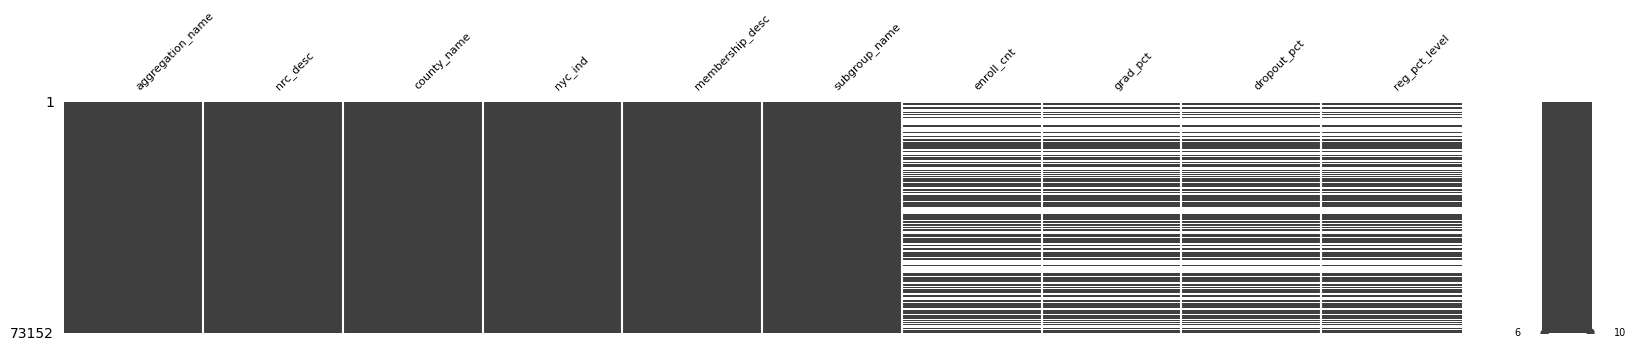

aggregation_name        0
nrc_desc                0
county_name             0
nyc_ind                 0
membership_desc         0
subgroup_name           0
enroll_cnt          33478
grad_pct            33478
dropout_pct         33478
reg_pct_level       33478
dtype: int64

In [14]:
msno.matrix(school_df, figsize = (20,3), fontsize = 8)
plt.show()

school_df.isna().sum()

The plot shows that the values are missing as whole rows. The rows with nulls in target clomun can be dropped as it does not have any predictive value.

<Axes: >

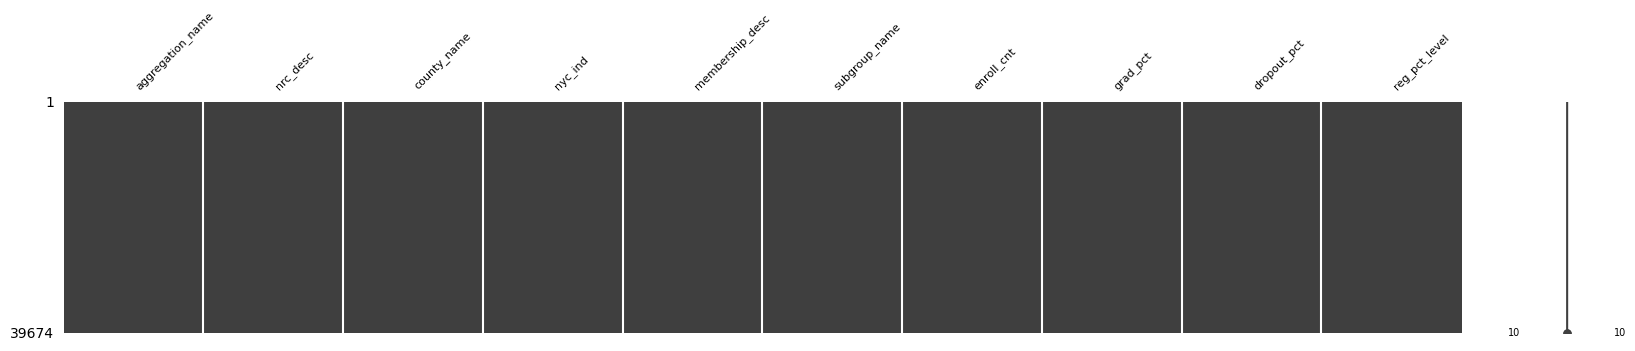

In [15]:
school_df.dropna(subset=['reg_pct_level'], inplace=True)

msno.matrix(school_df, figsize = (20,3), fontsize = 8)

# Prepped Data Review

<Axes: xlabel='reg_pct_level', ylabel='count'>

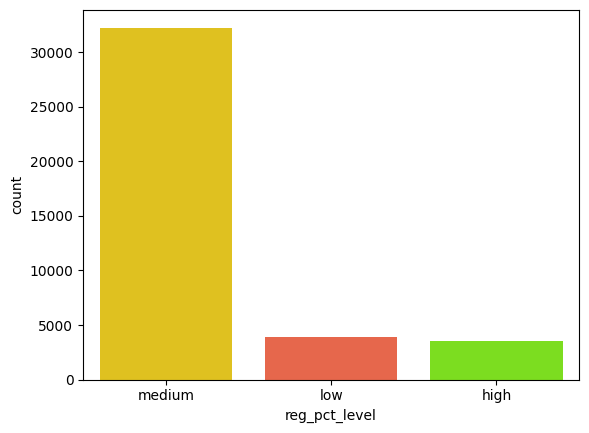

In [55]:
# Create a dictionary to map categories to colors
color_mapping = { 'low': '#FFD700', 'medium': '#FF5733','high': '#7CFC00'} 

sns.countplot(data = school_df, x = 'reg_pct_level', palette=color_mapping.values())

__Insights:__ The reg_pct_level column is comprised of 3 distinct categorical values, with the most frequently occurring value being medium. It's highly imbalanced when compared to low and high. 

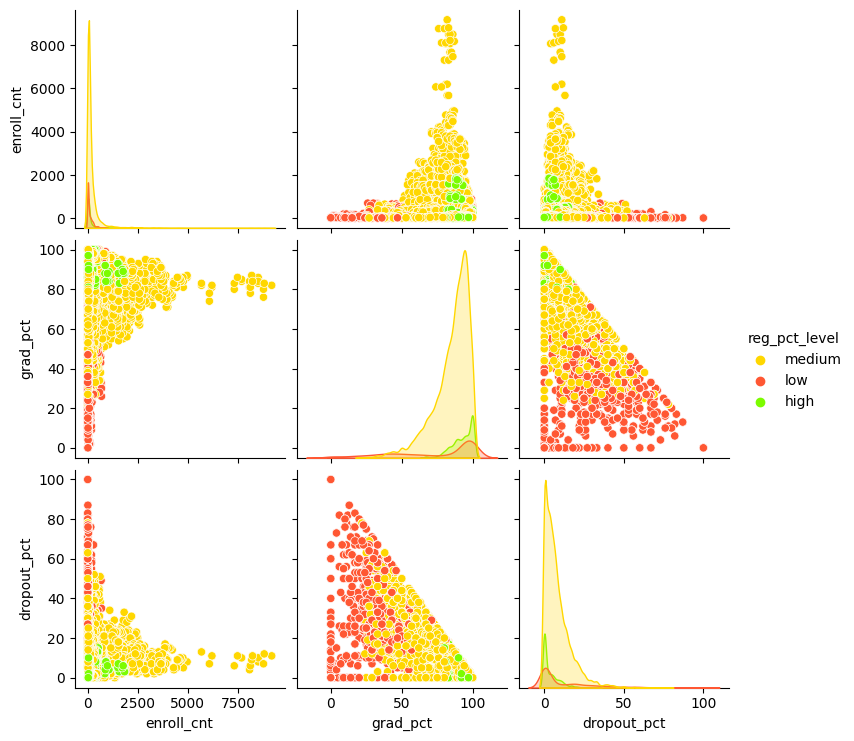

In [56]:
sns.pairplot(school_df[['enroll_cnt', 'grad_pct', 'dropout_pct', 'reg_pct_level']], hue = 'reg_pct_level', palette=color_mapping.values())

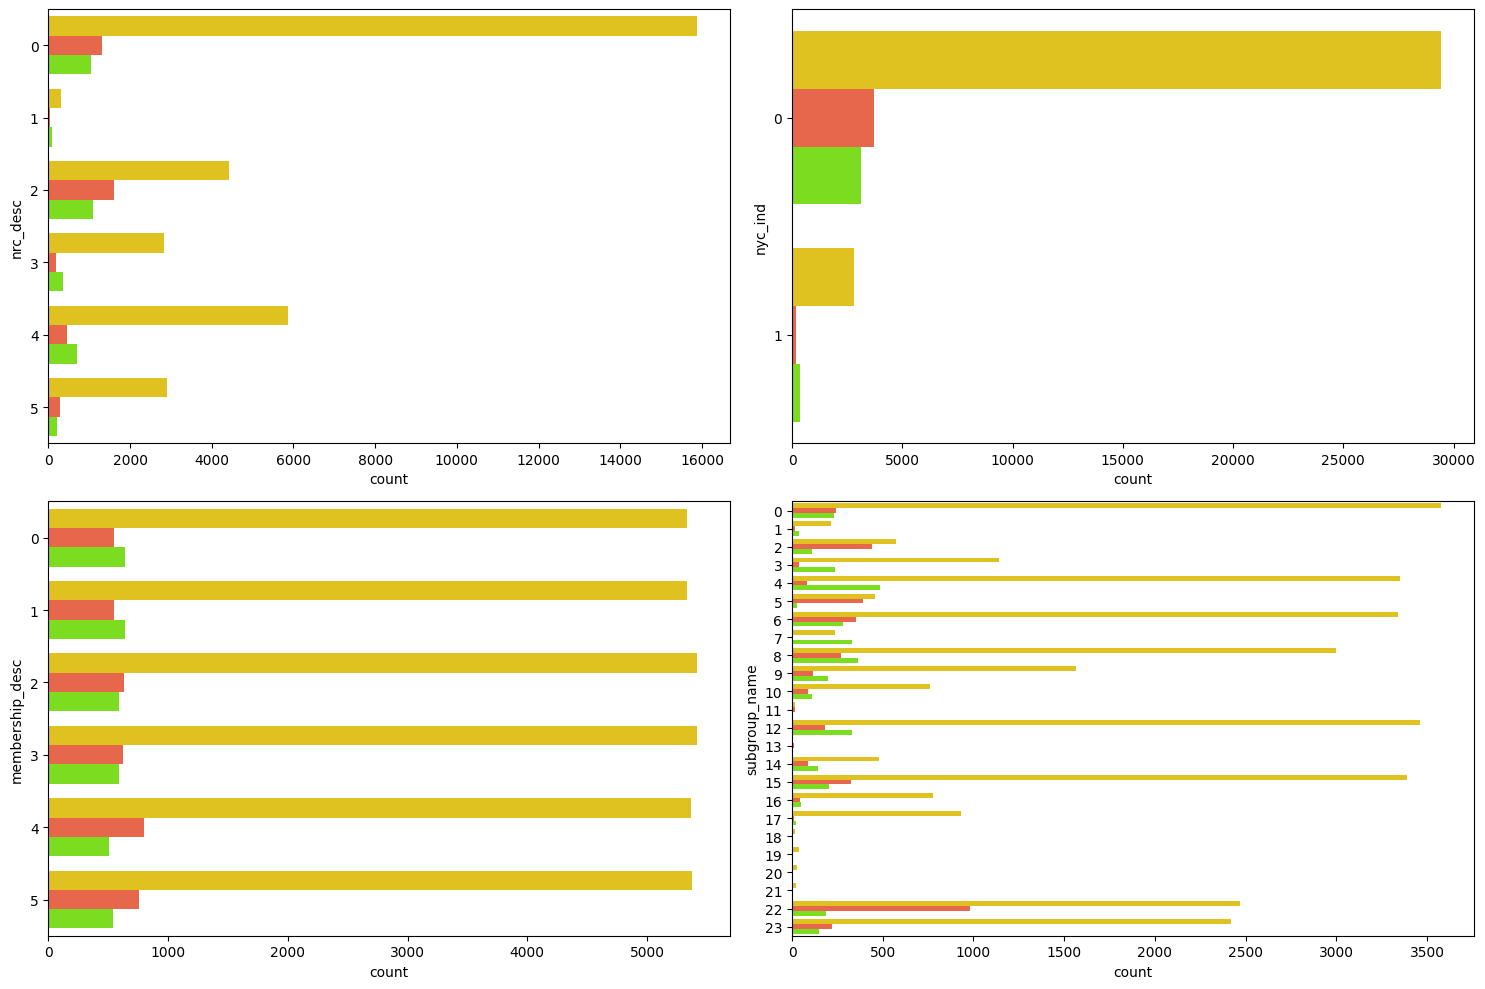

In [57]:
plt.figure(figsize=(15,10))
pos = 1
for col in ['nrc_desc', 'nyc_ind', 'membership_desc', 'subgroup_name']:
    
    plt.subplot(2,2,pos)
    sns.countplot(data = school_df, y= col, hue = 'reg_pct_level', palette=color_mapping.values())
    plt.legend().set_visible(False) 
    pos+=1

plt.tight_layout()
plt.show()


__Insights:__ We can obsereve that the classes follow similar distribution with Medium always being the highest while low and high classes are interchanging between different categories.

# Decision Tree + Random Forest Modeling

## Feature Engineering - Dummy Variables

In [19]:
# Creating a LabelEncoder object
label_encoder = preprocessing.LabelEncoder() 
  
encode_cols = ['aggregation_name', 'nrc_desc', 'county_name', 'nyc_ind', 'membership_desc', 'subgroup_name']

# Iterate through the encode_cols list and apply fit_transform method to encode the categories
for col in encode_cols:
    school_df[col]= label_encoder.fit_transform(school_df[col]) 

school_df.head()

,aggregation_name,nrc_desc,county_name,nyc_ind,membership_desc,subgroup_name,enroll_cnt,grad_pct,dropout_pct,reg_pct_level
0,4,5,0,0,0,0,658.0,71.0,22.0,medium
1,4,5,0,0,0,6,324.0,76.0,20.0,medium
2,4,5,0,0,0,12,334.0,65.0,25.0,medium
4,4,5,0,0,0,3,367.0,68.0,25.0,medium
5,4,5,0,0,0,9,98.0,59.0,29.0,medium


In [20]:
# Explanatory Variable
X = school_df.copy().drop('reg_pct_level', axis=1)
X.head(2)

,aggregation_name,nrc_desc,county_name,nyc_ind,membership_desc,subgroup_name,enroll_cnt,grad_pct,dropout_pct
0,4,5,0,0,0,0,658.0,71.0,22.0
1,4,5,0,0,0,6,324.0,76.0,20.0


In [21]:
# Response Variable
y = school_df['reg_pct_level']
y.head(2)

0    medium
1    medium
Name: reg_pct_level, dtype: object

## Feature Selection - Variance Inflation Factor(VIF)

In [22]:
def calculate_vif(df):
    
    '''
    Calculates the Variance Inflation Factor (VIF) for each feature in a pandas DataFrame.
    Args:
        df: A pandas DataFrame containing the features.
    Returns:
        A pandas DataFrame with the feature names and their corresponding VIF values, sorted in descending order of VIF.
    '''
    
    # VIF dataframe 
    vif_data = pd.DataFrame() 
    vif_data["feature"] = df.columns 

    # calculating VIF for each feature 
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

    # sort the VIF dataframe in descending order
    vif_data = vif_data.sort_values(by = 'VIF', ascending = False).reset_index(drop = True)

    return vif_data

In [23]:
print('Calculate VIF Scores and iteratively drop columns with highest VIF and VIF > 5. The following columns are dropped')

#Iterate the process until the highest VIF score is less than 5
while calculate_vif(X)['VIF'][0] > 5:
    
    top_vif_feature = calculate_vif(X)['feature'][0]
    top_vif_score = round(calculate_vif(X)['VIF'][0],2)

    print(f'{top_vif_feature}: {top_vif_score}')
    
    # Drop the column with highest VIF
    X = X.drop(top_vif_feature, axis = 1)

print(f'\nShape of resulted Dataframe : {X.shape}')

Calculate VIF Scores and iteratively drop columns with highest VIF and VIF > 5. The following columns are dropped
grad_pct: 8.85

Shape of resulted Dataframe : (39674, 8)


## Train Test Split

In [24]:
# Splitting the dataset into train and test sets
# X: features, y: target variable
# test_size=0.3: proportion of the dataset to include in the test split (30% in this case)
# random_state=1234: random seed for reproducibility
# stratify=y: ensures that the distribution of the target variable y is approximately equal in both the train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)

## Model Building: Decision tree

In [25]:
def decision_tree_grid_search(X, y, features=X.columns):

    """
    Perform grid search with cross-validation to tune hyperparameters for a decision tree classifier.

    Parameters:
    X (DataFrame): Features of the dataset.
    y (Series): Target variable of the dataset.
    features (list): List of feature columns to use (default is all columns of X).

    Returns:
    best_model (estimator): Best decision tree classifier model found during grid search.
    best_params (dict): Best hyperparameters found during grid search.
    best_accuracy (float): Mean cross-validated accuracy of the best model.
    """

    # Define the parameter grid
    param_grid = {
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [100, 150, 200, 250],
        'min_samples_split': [500, 800, 1000],
    }

    # Create the decision tree classifier
    dt_classifier = DecisionTreeClassifier(class_weight='balanced')

    # Create the GridSearchCV object
    grid_search = GridSearchCV(dt_classifier, param_grid, scoring='accuracy', cv=5)

    # Fit the model to the data
    grid_search.fit(X[features], y)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Get the best model
    best_model = grid_search.best_estimator_

    # Get the best accuracy
    best_accuracy = grid_search.best_score_

    # Return the best model, best parameters, and best accuracy
    return best_model, best_params, best_accuracy


In [26]:
#model1
#selected features = all
model1, parameters ,score = decision_tree_grid_search(X_train,y_train,)

print('best model:',model1,'\n parameters :', parameters, '\n score:' ,score)

best model: DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=150, min_samples_split=500) 
 parameters : {'max_depth': 5, 'min_samples_leaf': 150, 'min_samples_split': 500} 
 score: 0.6272725133514432


In [27]:
#model 2
selected_features2 = ['enroll_cnt', 'dropout_pct', 'subgroup_name', 'nyc_ind']
model2, parameters2, score2 = decision_tree_grid_search(X_train, y_train,selected_features2)
print('best model:', model2, '\nparameters:', parameters2, '\nscore:', score2)

best model: DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=100, min_samples_split=500) 
parameters: {'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 500} 
score: 0.6343668691680115


## Model Building: Random Forest

In [28]:
def random_forest_grid_search(X, y, features=X.columns):

    """
    Perform grid search with cross-validation to tune hyperparameters for a random forest classifier.

    Parameters:
    X (DataFrame): Features of the dataset.
    y (Series): Target variable of the dataset.
    features (list): List of feature columns to use (default is all columns of X).

    Returns:
    best_model (estimator): Best random forest classifier model found during grid search.
    best_params (dict): Best hyperparameters found during grid search.
    best_accuracy (float): Mean cross-validated accuracy of the best model.
    """
        
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [100, 150, 200, 250],
        'min_samples_split': [500, 800, 1000],
    }

    # Create the Random Forest classifier
    rf_classifier = RandomForestClassifier(class_weight='balanced')

    # Create the GridSearchCV object
    grid_search = GridSearchCV(rf_classifier, param_grid, scoring='accuracy', cv=5 ,verbose=1, n_jobs=-1)

    # Fit the model to the data
    grid_search.fit(X[features], y)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Get the best model
    best_model = grid_search.best_estimator_

    # Get the best accuracy
    best_accuracy = grid_search.best_score_

    # Return the best model, best parameters, and best accuracy
    return best_model, best_params, best_accuracy

In [29]:
# model 1
#selected_feautures= all
model_rf1, parameters_rf1, score_rf1 = random_forest_grid_search(X_train,y_train)
print('best model:', model_rf1, '\nparameters:', parameters_rf1, '\nscore:', score_rf1)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


best model: RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=100, min_samples_split=500) 
parameters: {'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 500, 'n_estimators': 100} 
score: 0.6762088416259703


In [30]:
# model 2
#selected_features2 = ['enroll_cnt', 'dropout_pct', 'subgroup_name', 'nyc_ind']
model_rf2, parameters_rf2, score_rf2 = random_forest_grid_search(X_train,y_train,selected_features2)
print('best model:', model_rf2, '\nparameters:', parameters_rf2, '\nscore:', score_rf2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


best model: RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=100, min_samples_split=500,
                       n_estimators=50) 
parameters: {'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 500, 'n_estimators': 50} 
score: 0.6282452847373323


# Select Models

## Cross Validation

In [47]:
# Dictionary to store cross-validation results
cross_val_results = {}

# Compute mean cross-validation score for each model and store in the dictionary
cross_val_results['Decision Tree Model 1'] = cross_val_score(model1, X_train, y_train, cv=5).mean().round(4)
cross_val_results['Decision Tree Model 2'] = cross_val_score(model2, X_train, y_train, cv=5).mean().round(4)
cross_val_results['Random Forest Model 1'] = cross_val_score(model_rf1, X_train, y_train, cv=5).mean().round(4)
cross_val_results['Random Forest Model 2'] = cross_val_score(model_rf2, X_train, y_train, cv=5).mean().round(4)

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame.from_dict(cross_val_results, orient='index', columns=['Mean_CV_Score'])

results_df

,Mean_CV_Score
Decision Tree Model 1,0.6273
Decision Tree Model 2,0.5914
Random Forest Model 1,0.6733
Random Forest Model 2,0.6655


Random Forest Model 1 performs the best with an accuracy of 67.3%

## Unseeen Data

Evaluation on Test Set:


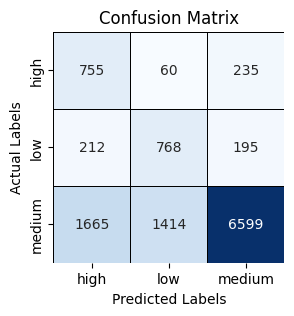


Classification Report:
              precision    recall  f1-score   support

        high       0.29      0.72      0.41      1050
         low       0.34      0.65      0.45      1175
      medium       0.94      0.68      0.79      9678

    accuracy                           0.68     11903
   macro avg       0.52      0.68      0.55     11903
weighted avg       0.82      0.68      0.72     11903



{'Accuracy': 0.68, 'Precision': 0.82, 'Recall': 0.68, 'F1-Score': 0.72}

In [54]:
# Evaluate the model on the test set
y_pred_test = model_rf1.predict(X_test)

print("Evaluation on Test Set:")
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix as heatmap
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True, cbar=False, linecolor='black', linewidths=0.5,
            xticklabels=['high', 'low', 'medium'],
            yticklabels=['high', 'low', 'medium'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Calculate evaluation metrics
{
'Accuracy': round(accuracy_score(y_test, y_pred_test), 2),
'Precision': round(precision_score(y_test, y_pred_test, average='weighted'), 2),
'Recall': round(recall_score(y_test, y_pred_test, average='weighted'), 2),
'F1-Score': round(f1_score(y_test, y_pred_test, average='weighted'), 2)
}

# Conclusions

The exploratory data analysis (EDA) played a pivotal role in identifying outliers and correlated features. Leveraging these insights, we strategically removed insignificant columns and handled null values. In feature engineering, we encoded categorical columns into dummy variables.  And utilized VIF to remove collinear features.

Finally, we built 2 set of decision tree and random forest models with different sets of features. We also employes grid search for hyperparameter tuning. On evaluating the model's performance using cross validation we confidently found that Random Forest Model 1 outperforms the other models with an accuracy of 67.3%. On applying the model to a previously unseen data our model performs well with accuracy of 68% and F-1 Score of 0.72.

Throughout the process, we curated the dataset, addressing nulls, categorical encoding, and class imbalances. Leveraging advanced modelling techniques and evalution,  we ultimately recognize the Random Forest Model 1's dominance in predictive accuracy and stability.